This notebook demonstrates the use of the CausalML implemented DR Learner by Kennedy (2020) (https://arxiv.org/abs/2004.14497) for the Individual Treatment Effect (ITE) estimation.

In [24]:
%load_ext autoreload
%autoreload 2

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

# Synthetic Data Generation

In [9]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

# Comparing DR Learner with X Learner

We use a flexible ML estimator to estimate the outcome model but a simple linear regression model to estimate the ITE, since the ITE estimate is often noisy and prone to overfit with a flexible estimator.

In [49]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)

In [47]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X, treatment=treatment, y=y)

DR Learner outforms X Learner in this dataset. Even with built-in mechanism to counteract the unbalancedness between the treatment and control samples, X Learner still suffers from the regime where the treatment probability is close to 1 in this case.

Text(0.5, 1.0, 'DR Learner')

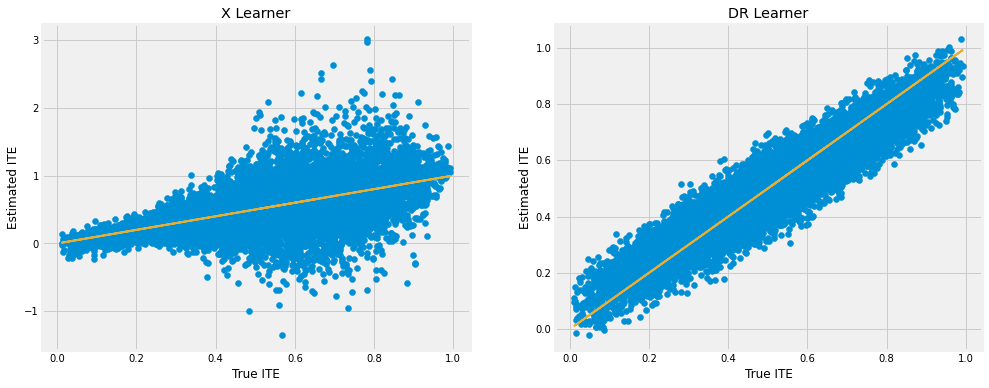

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau, cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau, cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')